In [196]:
import numpy as np
from enum import Enum

Methods = Enum('Methods', ['Classic', 'Momentum', 'AdaGrad', 'RMSprop', 'Adam', 'Nesterov'])


class LinearRegression:
    def __init__(self, T, W, X, Y):
        self.T = np.array([T[i % len(T)](X[i // len(T)]) for i in range(len(T) * len(X))]).reshape(len(X), len(T))
        self.W = W
        self.X = X
        self.Y = Y

    def loss_function_value(self, W_Arg):
        val = sum([(np.dot(self.T[i], W_Arg) - self.Y[i]) ** 2 for i in range(len(self.X))])
        return val

    def grad_by_components(self, index_components, W_Arg):
        batch = np.zeros(len(W_Arg))
        for i in index_components:
            batch += 2 * (np.dot(self.T[i], W_Arg) - self.Y[i]) * self.T[i]

        return batch


def sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, beta_2, eps_adam, is_corr_beta_1=True, is_corr_beta_2=True, is_nesterov=False):
    i = 0
    prev_W = lin_reg.loss_function_value(lin_reg.W)
    V = np.zeros(len(lin_reg.W))
    S = np.zeros(len(lin_reg.W))
    while True:
        components = [(i * batch + j) % len(lin_reg.X) for j in range(batch)]
        grad_with_batch = lin_reg.grad_by_components(components, lin_reg.W)
        alpha = lr(lambda a: lin_reg.loss_function_value(lin_reg.W - a * grad_with_batch))
        V = (beta_1 * V) + (1 - beta_1) * grad_with_batch if ~is_nesterov else (beta_1 * V) + (1 - beta_1) * lin_reg.grad_by_components(lin_reg.W - alpha * beta_1 * V)
        S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2)
        V_norm = V / (1 - (beta_1 ** (i + 1))) if is_corr_beta_1 else V
        S_norm = S / (1 - (beta_2 ** (i + 1))) if is_corr_beta_2 else S
        lin_reg.W -= alpha * (V_norm / (((S_norm) + eps_adam) ** 0.5))
        if abs(lin_reg.loss_function_value(lin_reg.W) - prev_W) < eps or i >= max_num_of_step:
            break
        prev_W = lin_reg.loss_function_value(lin_reg.W)
        i += 1


def sgd_handler(lin_reg, lr, method, batch=1, beta_1=0.9, beta_2=0.999, eps_adam=10 ** -8, eps=0.001, max_num_of_step=10000):
    match method:
        case Methods.Classic:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, 0, 1, 1, False, False)
        case Methods.Momentum:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, 1, 1, False, False)
        case Methods.AdaGrad:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, 0, 0, eps_adam, False, False)
        case Methods.RMSprop:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, 0, beta_2, eps_adam, False)
        case Methods.Adam:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, beta_2, eps_adam)
        case Methods.Nesterov:
            sgd(lin_reg, lr, eps, batch, max_num_of_step, beta_1, 1, 1, False, False, True)


def lr_dichotomy(eps, delt):
    return lambda lin_reg: dichotomy(lin_reg, 0, right_border_calc(lin_reg), eps, delt)


def right_border_calc(func):
    right_start = 0.0000001
    zero = func(0.)
    while zero >= func(right_start):
        right_start *= 1.3

    return right_start


def dichotomy(func, a_1, a_2, eps, delt):
    while abs(a_1 - a_2) >= eps:
        new_a_1 = (a_1 + a_2) / 2 - delt
        new_a_2 = (a_1 + a_2) / 2 + delt
        fv1 = func(new_a_1)
        fv2 = func(new_a_2)
        if fv2 > fv1:
            a_2 = new_a_2
        elif fv2 < fv1:
            a_1 = new_a_1
        else:
            a_1 = new_a_1
            a_2 = new_a_2
    return (a_1 + a_2) / 2

In [197]:
import matplotlib.pyplot as plt


def visualise_points(linear_reg):
    x = np.linspace(-10, 10, 1000)
    y = linear_reg.W[0] * x + linear_reg.W[1]
    plt.plot(x, y, '-r')
    plt.plot(linear_reg.X, linear_reg.Y, 'og', linestyle='None')
    plt.xlabel("x")
    plt.show()
    print(linear_reg.W)
    print(linear_reg.loss_function_value(linear_reg.W))

Methods.Classic for const lr


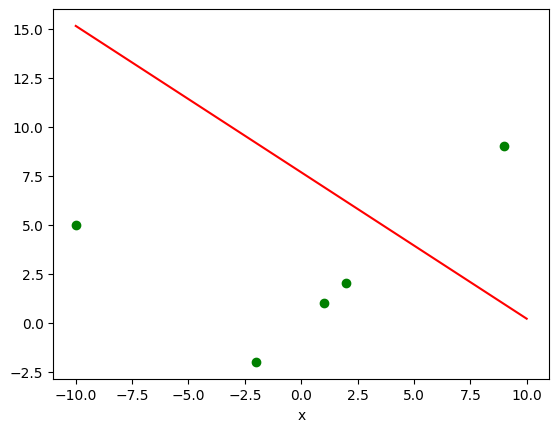

[-0.74654709  7.66981717]
344.65291429435626



Methods.Momentum for const lr


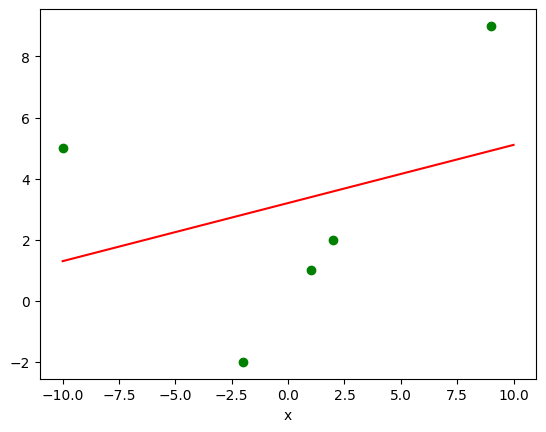

[0.19031467 3.20193538]
61.860453850394336



Methods.AdaGrad for const lr


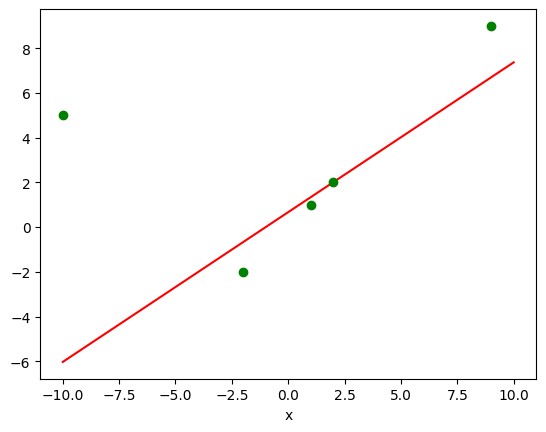

[0.6700228  0.67009049]
128.83737210397575



Methods.RMSprop for const lr


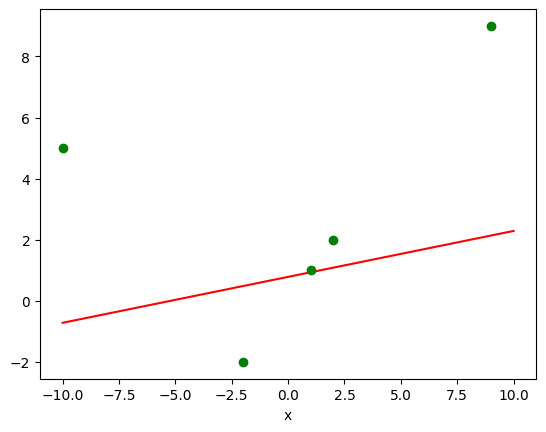

[0.15036546 0.78441985]
86.81059687458041



Methods.Adam for const lr


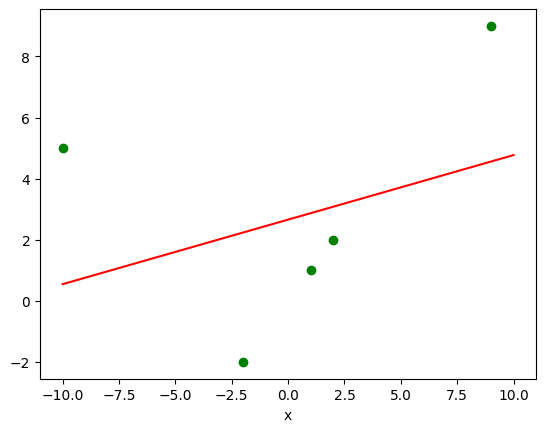

[0.21129314 2.65830794]
62.162826395123446



Methods.Nesterov for const lr


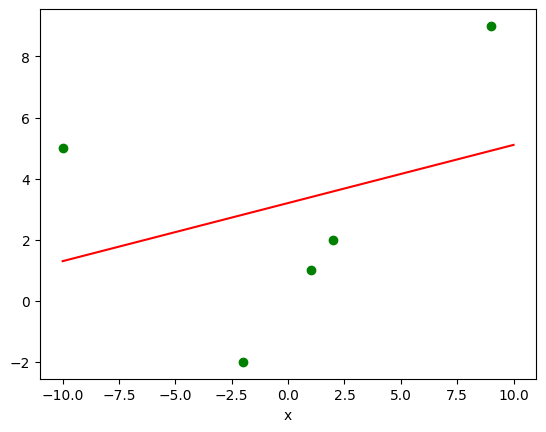

[0.19031467 3.20193538]
61.860453850394336



Methods.Classic for dichotomy lr




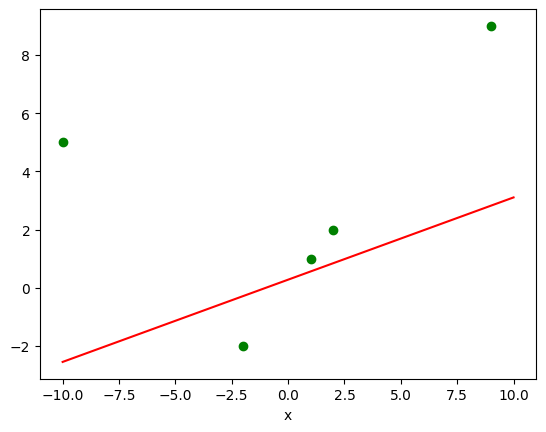

[0.28256078 0.28256067]
99.48723323888015



Methods.Momentum for dichotomy lr




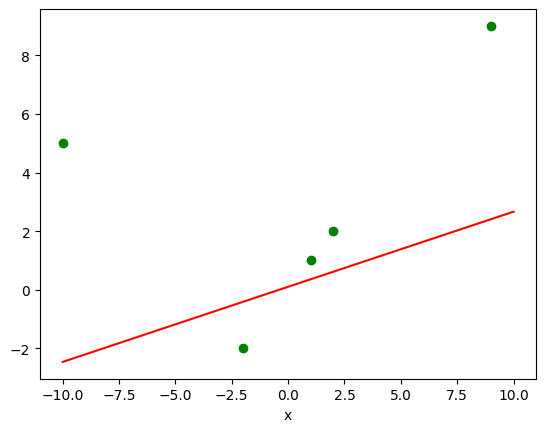

[0.25618592 0.10210597]
103.96400819929238



Methods.AdaGrad for dichotomy lr




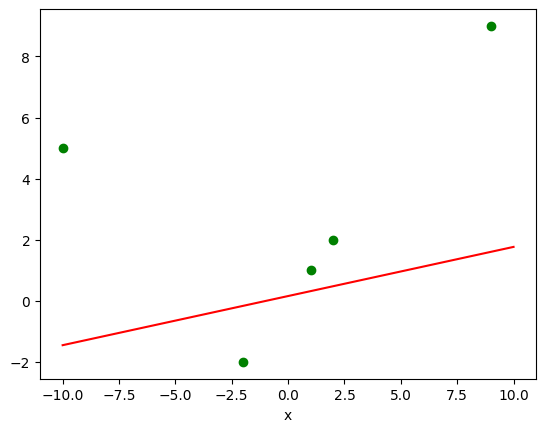

[0.16090079 0.15676737]
102.46671811199005



Methods.RMSprop for dichotomy lr




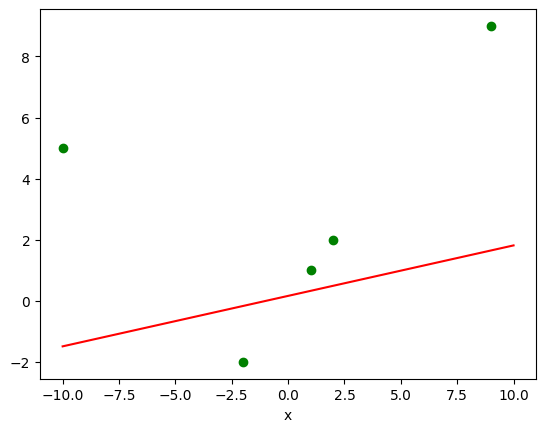

[0.16524125 0.16197502]
102.24051638442702



Methods.Adam for dichotomy lr




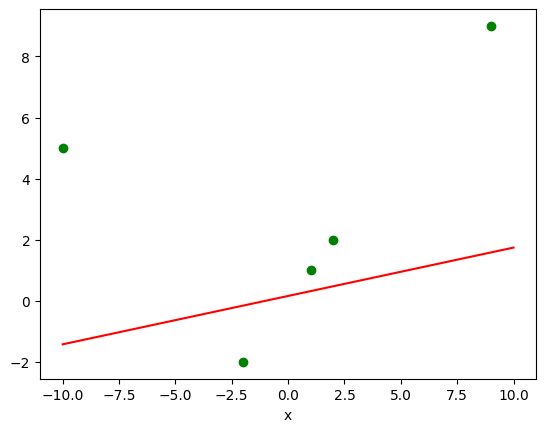

[0.15837396 0.15956666]
102.43603032061725



Methods.Nesterov for dichotomy lr




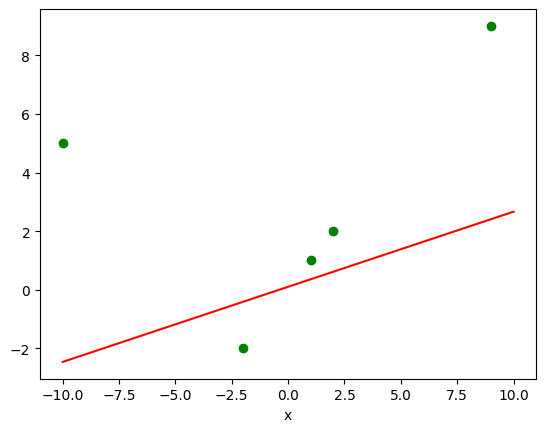

[0.25618592 0.10210597]
103.96400819929238





In [198]:
current_t = np.array([lambda x: x, lambda x: 1.])
current_w = np.array([0., 0.])
current_x = np.array([1., 2., 9., -2., -10.])
current_y = np.array([1., 2., 9., -2., 5])

for method in Methods:
    linear_reg_const = LinearRegression(
        current_t, current_w, current_x, current_y
    )
    print(str(method) + " for const lr")
    sgd_handler(linear_reg_const, lambda x: 0.01, method)
    visualise_points(linear_reg_const)
    current_w = np.array([0., 0.])
    print("\n\n")

for method in Methods:
    linear_reg_dichotomy = LinearRegression(
        current_t, current_w, current_x, current_y
    )
    print(str(method) + " for dichotomy lr" + "\n\n")
    sgd_handler(linear_reg_dichotomy, lr_dichotomy(0.001, 0.0001), method)
    visualise_points(linear_reg_dichotomy)
    current_w = np.array([0., 0.])
    print("\n\n")